# Classification

## Sources

src: https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

## Imports

In [153]:
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# data handling
import pandas as pd
import numpy as np
import time
from scipy.stats import randint
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# interpretation
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import plot_partial_dependence

## Prepare Data

In [154]:
trainDF = pd.read_csv('../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../app/data/02_test.csv', sep=';')

>Prepare for classification by creating ranges for the totalPrice column

In [155]:
trainDF.describe().totalPrice

count    219943.000000
mean        350.116172
std         232.890170
min           0.100000
25%         205.000000
50%         295.000000
75%         428.000000
max       18130.000000
Name: totalPrice, dtype: float64

In [156]:
testDF.describe().totalPrice

count    94262.000000
mean       349.123993
std        228.231882
min          0.100000
25%        204.625000
50%        294.000000
75%        425.000000
max       5700.000000
Name: totalPrice, dtype: float64

In [157]:
bins = [i for i in range(0, 1010, 20)]
bins.append(float('Inf'))

labels = [i for i in range(0, len(bins)-1, 1)]  # Bin labels must be one fewer than the number of bin edges

idx=0
totalPriceMapping = {}
for i in labels:
    totalPriceMapping[labels[idx]]=f"{bins[idx]} - {bins[idx+1]}"
    idx+=1

print("bins:", bins)
print("labels:", labels)
print("\ntotalPrice mapping:")
print(totalPriceMapping)

bins: [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, inf]
labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

totalPrice mapping:
{0: '0 - 20', 1: '20 - 40', 2: '40 - 60', 3: '60 - 80', 4: '80 - 100', 5: '100 - 120', 6: '120 - 140', 7: '140 - 160', 8: '160 - 180', 9: '180 - 200', 10: '200 - 220', 11: '220 - 240', 12: '240 - 260', 13: '260 - 280', 14: '280 - 300', 15: '300 - 320', 16: '320 - 340', 17: '340 - 360', 18: '360 - 380', 19: '380 - 400', 20: '400 - 420', 21: '420 - 440', 22: '440 - 460', 23: '460 - 480', 24: '480 - 500', 25: '500 - 520', 26: '520 - 540', 27: '540 - 560', 28: '560 - 580', 29: '580 - 600', 30: '600 - 620', 31: '6

In [158]:
trainDF['totalPrice'] = pd.cut(trainDF['totalPrice'], bins=bins, labels=labels)  # change totalPrice column to categorial feature with above devined ranges/labels
testDF['totalPrice'] = pd.cut(testDF['totalPrice'], bins=bins, labels=labels)  # change totalPrice column to categorial feature with above devined ranges/labels

In [159]:
trainDF.head(10)

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,17
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,15
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,15
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,20
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,33
5,116.387037,39.959170,52.21,1,1,1,1,6,118742,81441,...,133606,219943,708829.0,40.6,2014,10,25,82499,13370,14
6,116.365511,40.036171,85.63,2,1,1,1,13,58087,81641,...,133606,219943,3133469.0,426.0,2012,6,23,48571,136686,10
7,116.378897,40.015057,51.31,1,1,1,1,14,41617,81441,...,81988,219943,3452460.0,470.8,2017,4,20,82499,136686,19
8,116.587907,39.920397,66.03,2,1,1,1,7,118742,53150,...,133606,219943,3452460.0,470.8,2015,2,9,18058,136686,9
9,116.411493,40.000186,106.92,2,2,1,1,15,41617,81441,...,81988,219943,3452460.0,470.8,2017,7,25,44240,136686,38


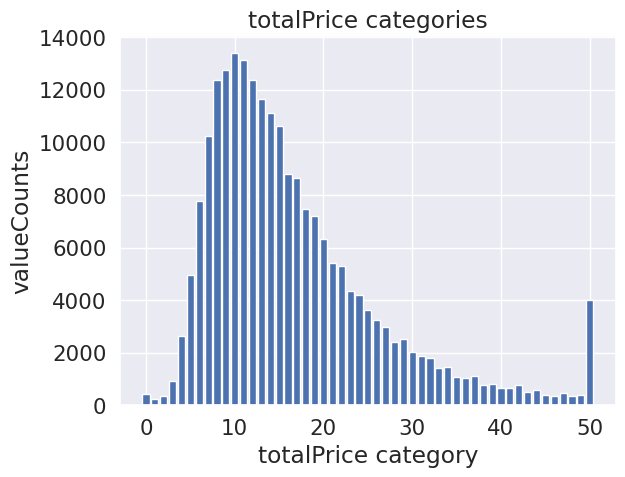

In [160]:
plt.bar(trainDF["totalPrice"].value_counts().index, trainDF["totalPrice"].value_counts().values)
plt.title("totalPrice categories")
plt.xlabel("totalPrice category")
plt.ylabel("valueCounts")
plt.show()

In [161]:
columns = trainDF.columns.to_list()
print(columns)

['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod', 'totalPrice']


In [162]:
X_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
X_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [163]:
X_train

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,communityAverage,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,39243.0,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,92516.0,133606,219943,3452460.0,470.8,2013,5,14,82499,136686
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,73113.0,133606,219943,3452460.0,470.8,2012,12,29,18058,136686
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,54612.0,81988,219943,3452460.0,470.8,2015,4,9,25725,136686
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,57510.0,81988,219943,3452460.0,470.8,2017,12,7,82499,136686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219938,116.451461,39.949365,57.49,2,1,1,1,6,118742,81641,...,72137.0,81988,219943,3452460.0,470.8,2012,12,15,48571,136686
219939,116.229624,39.915004,44.10,1,1,1,1,6,118742,81641,...,51471.0,81988,219943,3133469.0,426.0,2012,7,7,82499,16497
219940,116.310205,39.987486,138.14,3,2,1,2,16,58087,81641,...,79927.0,81988,219943,3133469.0,426.0,2011,12,5,44240,136686
219941,116.389264,39.886874,96.90,2,1,2,1,16,58087,81441,...,91507.0,4349,219943,1106214.0,46.5,2015,3,21,44240,136686


In [164]:
y_train

0         17
1         15
2         15
3         20
4         33
          ..
219938    10
219939     5
219940    11
219941    24
219942    14
Name: totalPrice, Length: 219943, dtype: category
Categories (51, int64): [0 < 1 < 2 < 3 ... 47 < 48 < 49 < 50]

## ML

### XGBClassifier

In [165]:
clf = XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test, y_pred)

/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.29153847785958287

### RandomForestClassifier

In [ ]:
clf = RandomForestClassifier()
grid_space={'max_depth':list(np.arange(10, 40, step=10)) + [None],
              'n_estimators':np.arange(10, 300, step=50),
              'max_features':randint(1,6),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(1, 5, step=1)
          }
grid = RandomizedSearchCV(clf,param_distributions=grid_space,cv=3,scoring='accuracy', n_jobs=-1)
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

In [ ]:
print (f'Train Accuracy - : {grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {grid.score(X_test,y_test):.3f}')

In [ ]:
clf = RandomForestClassifier()
grid_space={'max_depth':[3,5,10,20,30],
            'n_estimators':[10,100,200],
            'max_features':[1,2,3,4,5,6],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[1,2,3]
            }
grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

In [ ]:
print (f'Train Accuracy - : {grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {grid.score(X_test,y_test):.3f}')

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = bins  # defined above
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# DF with predictions
predDF = X_test
predDF["totalPrice"] = y_test
predDF["prediction"] = y_pred
predDF.head()

In [ ]:
predDF["totalPrice"].describe()

In [ ]:
predDF["prediction"].describe()

## Visualization & Interpretation

In [ ]:
columns=['square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod']

plt.figure(figsize=(25,25))
i=0
for groupByFeature in columns:
    i+=1
    plt.subplot(6,4,i)
    plt.scatter(predDF.groupby(["prediction"]).mean().index, predDF.groupby(["prediction"]).mean()[groupByFeature])
    plt.title(f"grouped by {groupByFeature}")
    plt.xlabel("prediction")
    plt.ylabel(groupByFeature)
    plt.xticks([i for i in range(0, len(bins)+1, 5)])
plt.tight_layout()
plt.show()